# Example: Modeling European Call or Put Contract Premiums
This example will familiarize students with computing the premium of European call and put contracts using both the Monte Carlo simulation approach and the Black-Scholes pricing formula. 

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Compute European option premiums using Monte Carlo simulation:__ Estimate option prices by simulating asset price paths under risk-neutral dynamics and averaging discounted payoffs.
> * __Apply the Black-Scholes-Merton formula:__ Use the analytical BSM model to calculate precise premiums for European call and put options given market parameters.
> * __Analyze premium sensitivity to strike price:__ Understand and visualize how European call and put option premiums change as the strike price varies relative to the current asset price.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

## Task 1: Compute the premium for European-style call contracts
In this task we'll compute the premium for European-style call contracts using both the [Monte Carlo simulation approach](https://en.wikipedia.org/wiki/Monte_Carlo_method) and the [Black-Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_model).

__Parameters:__ We have a European call that expires in T = 365 days with a strike price of K = 60.0 USD/share. The current share price is $S(0)$ = 60.0 USD/share. Assume a risk-free rate of return of 5% and an implied volatility of 10%. The correct premium is $\mathcal{P}_{c}(K,S(0))$ = 4.08 USD/share.

Let's compute the European call premium using two approaches:
* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes-Merton](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European call option contract

We start by defining the problem parameters that are shared between the approaches:

In [2]:
Δt = (1.0/365.0); # time step: 1 x day (in 365-day years)
Sₒ = 60.0; # initial share price
K = 60.0; # strike price
T = 365.0*Δt; # time to expiration (in years)
r̄ = 0.05; # risk-free rate of return
σ̄ = 0.10; # implied volatility (annualized standard deviation of returns)
𝒟(r,T) = exp(r*T); # discount function

### Approach 1: Monte Carlo estimate of European call contract price
First, let's compute the premium for the European call contract using the Monte Carlo simulation approach.
The premium (cost) for each __call__ contract is governed by the following arbitrage-free risk-neutral pricing condition. For a __European-style call__, the premium is:
$$
\begin{align*}
\mathcal{P}_{c}^{\text{EU}}(K,S(0)) = \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{c}}(K,S(T))\Bigr)\quad\text{(European call)}
\end{align*}
$$
where $V_{c}(K,S(T)) = \max(0, S(T) - K)$ is the __call__ contract payoff at expiration time $T$. We'll use Monte Carlo simulation to estimate the expectation by sampling the geometric Brownian motion model for the share price at time $T$, assuming risk-neutral dynamics.

We'll start by building an instance [of the `MyGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds the parameters for the price simulation using [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple%7BType%7BMyGeometricBrownianMotionEquityModel%7D,%20NamedTuple%7D), and store this instance in the `model` variable:

In [3]:
model = build(MyGeometricBrownianMotionEquityModel, (
        μ = r̄, σ = σ̄)); # pass in the model parameters

Next, we build an instance of [the `MyEuropeanCallContractModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyEuropeanCallContractModel), which holds the parameters for the call contract [using the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyEuropeanCallContractModel},%20NamedTuple}). We store the contract model in the `call_contract_model` variable:

In [4]:
call_contract_model = build(MyEuropeanCallContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1, copy = 1));

Generate different numbers of sample paths and store these in the `number_of_samples` array.
We'll use these values to demonstrate the influence of sample size on the accuracy of the premium calculation:

In [5]:
number_of_samples = range(1.0,stop=5,step=1.0) |> collect |> (x-> exp10.(x)) |> (x-> 5*Int.(x));

Finally, we'll solve the geometric Brownian motion model for each number of sample paths using a `for` loop. For each pass of the loop: 
* First, we sample the geometric Brownian model instance [using the `sample_endpoint(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample_endpoint-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) and compute the payoff at contract expiration using [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff), storing the results in the `P` array.
* Next, we compute the discounted payoff array stored in the `P̄` array, then calculate the mean and standard error of the expected discounted future contract payoff. The mean value of the `P̄` array is the contract premium. 
* Finally, we populate [a `DataFrame` instance](https://github.com/JuliaData/DataFrames.jl) that holds the data (number of paths, premium, the standard error `SE`, and the 95% CI) for each number of sample paths.

So what do we get?

In [6]:
call_price_df = let
    call_price_df = DataFrame();
    for n ∈ number_of_samples
        S = sample_endpoint(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
        P = payoff([call_contract_model], S);
        P̄ = (1/𝒟(r̄,T))*P[:,3];
        mean_value = mean(P̄);
        std_error_value = (1.0/sqrt(n))*std(P̄);
        CI95_value = 1.96*std_error_value;
        
        results_df = (
            n = n,
            mean_premium = mean_value,
            SE = std_error_value,
            CI95 = CI95_value
        );
        
        push!(call_price_df, results_df);
    end
  
    pretty_table(
        call_price_df;
        backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- -------------- ------------ -----------
       n   mean_premium           SE        CI95 
   Int64        Float64      Float64     Float64 
 -------- -------------- ------------ -----------
      50        4.67514     0.574976     1.12695
     500        4.04975      0.20369    0.399232
    5000        4.15165    0.0663304    0.130008
   50000         4.0928    0.0208129   0.0407933
  500000        4.07681   0.00655794   0.0128536
 -------- -------------- ------------ -----------


### Approach 2: Black–Scholes-Merton pricing formula for a European call contract
We've implemented [a `premium(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium-Tuple{MyEuropeanCallContractModel,%20MyBlackScholesContractPricingModel}) that uses the Black–Scholes-Merton pricing formula to compute the premium of a European-style options contract. First, create an instance of [the `MyBlackScholesContractPricingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyBlackScholesContractPricingModel), which holds the risk-free rate $\bar{r}$ and the initial share price $S_{0}$. 

We store this instance in the `bsm_model::MyBlackScholesContractPricingModel` variable:

In [7]:
bsm_model = build(MyBlackScholesContractPricingModel, (
        Sₒ = Sₒ, r = r̄
));

Then we pass this instance, a European call or put model, to [the `premium(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium-Tuple{MyEuropeanCallContractModel,%20MyBlackScholesContractPricingModel}), which returns the premium value `𝒫`:

In [8]:
𝒫 = premium(call_contract_model, bsm_model)
println("The premium for the European call contract computed by Black-Scholes-Merton is: $(𝒫) USD/share")

The premium for the European call contract computed by Black-Scholes-Merton is: 4.083 USD/share


___

## Task 2: Compute the premium for European-style put contracts
In this task we'll compute the premium for European-style put contracts using both the [Monte Carlo simulation approach](https://en.wikipedia.org/wiki/Monte_Carlo_method) and the [Black-Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_model).

__Parameters:__ We have a European put that expires in T = 365 days with a strike price $K$ = 60.0 USD/share. The current share price is $S(0)$ = 60.0 USD/share. Assume a risk-free rate of return of 5% and an implied volatility of 10%. The correct answer is $\mathcal{P}_{p}(K,S(0))\simeq$ 1.16 USD/share.

Let's compute the premium using two approaches:
* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European put option contract

Let's start by defining the put contract model, and then computing the premium using both approaches.

#### Approach 1: Monte Carlo estimate of European put contract price
The premium (cost) for each __put__ contract is governed by the following arbitrage-free risk-neutral pricing condition. For a __European-style put__, the premium is:
$$
\begin{align*}
\mathcal{P}_{p}^{\text{EU}}(K,S(0)) = \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T))\Bigr)\quad\text{(European put)}
\end{align*}
$$
where $V_{p}(K,S(T)) = \max(0, K - S(T))$ is the __put__ contract payoff at expiration time $T$. We'll use Monte Carlo simulation to estimate the expectation by sampling the geometric Brownian motion model for the share price at time $T$, assuming risk-neutral dynamics.

Let's build an instance of [the `MyEuropeanPutContractModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyEuropeanPutContractModel), which holds the parameters for the put contract using [a `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyEuropeanPutContractModel},%20NamedTuple}). We store the contract model in the `put_contract_model` variable:

In [9]:
put_contract_model = build(MyEuropeanPutContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1, copy = 1));

Then repeat the simulation routine shown on the call contract case, but now we use the `put_contract_model` instance in place of the `call_contract_model` we used previously:

In [10]:
let
    
    # initialize -
    put_price_df = DataFrame();
    
    # let's run the computation for a different number of sample paths -
    for n ∈ number_of_samples
        S = sample_endpoint(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
        P = payoff([put_contract_model], S);
        P̄ = (1/𝒟(r̄,T))*P[:,3];
        mean_value = mean(P̄);
        std_error_value = (1.0/sqrt(n))*std(P̄);
        CI95_value = 1.96*std_error_value;
        
        results_df = (
            n = n,
            mean_premium = mean_value,
            SE = std_error_value,
            CI95 = CI95_value
        );
        push!(put_price_df, results_df);
    end
    
    pretty_table(
         put_price_df;
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- -------------- ------------ ------------
       n   mean_premium           SE         CI95 
   Int64        Float64      Float64      Float64 
 -------- -------------- ------------ ------------
      50       0.673097     0.191674     0.375682
     500        1.28859     0.109544     0.214706
    5000        1.15838    0.0323953    0.0634947
   50000         1.1843    0.0103373    0.0202611
  500000        1.15463   0.00322552   0.00632201
 -------- -------------- ------------ ------------


### Approach 2:  Black–Scholes-Merton pricing formula for a European put contract
Like the call contract case, we'll use [the `premium(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium), which uses the Black–Scholes-Merton pricing formula to compute the premium of a European-style options contract. 

We pass the [previous `MyBlackScholesContractPricingModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyBlackScholesContractPricingModel) and the new `put_contract_model` instance to [the `premium(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium-Tuple{MyEuropeanPutContractModel,%20MyBlackScholesContractPricingModel}), which returns the premium value `𝒫` for the put contract:

In [11]:
𝒫 = premium(put_contract_model, bsm_model)
println("The premium for the European put contract computed by Black-Scholes is: $(𝒫) USD/share")

The premium for the European put contract computed by Black-Scholes is: 1.156765470042835 USD/share


___

## Task 3: Premium versus the strike price for European call and put contracts
In this task, we explore how the premium for European-style call and put contracts varies as a function of the strike price `K` relative to the current share price $S_{0}$.

Let's compute this relationship for the call and put contracts we just considered. We calculate the premium for strike prices ranging from K=20 to K=100, all other parameters held constant (DTE = 365 days, IV = 0.10, $S_{0}$ = 60 USD/share). We record the estimated premium for call and put contracts in the `df_BSM_simulation` variable, which is [type `DataFrame` exported from the DataFrames.jl package](https://dataframes.juliadata.org/stable/). 

For each strike price in the `strikes` array:
* We first use [the `build(…)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyEuropeanCallContractModel},%20NamedTuple}) to create an instance of [the `MyEuropeanCallContractModel` and `MyEuropeanPutContractModel` types](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyEuropeanCallContractModel) containing information about the contracts. This is stored in the `call_contract_model` (or `put_contract_model`) variables. 
* Next, we calculate the premium for each contract [using the `premium(…)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium-Tuple{MyEuropeanCallContractModel,%20MyBlackScholesContractPricingModel}).
* Finally, we store the strike price `K` and the premium for the call and put contracts in the `df_BSM_simulation` variable.

So what do we get?

In [ ]:
df_BSM_simulation = let
    
    # initialize -
    start_strike = 20.0;
    stop_strike = 100.0;
    strikes = range(start_strike, stop = stop_strike, step=1) |> collect;
    df_BSM_simulation = DataFrame()
    
    # loop over strikes -
    for strike ∈ strikes
        
        call_contract_model = build(MyEuropeanCallContractModel, (
            K = strike, IV = σ̄, DTE = T, sense = 1));
        
        put_contract_model = build(MyEuropeanPutContractModel, (
            K = strike, IV = σ̄, DTE = T, sense = 1));
        
        P_call = premium(call_contract_model, bsm_model); # compute premium
        P_put = premium(put_contract_model, bsm_model); # compute premium
        
        results_tuple = (
            strike = strike,
            premium_call = P_call, 
            premium_put = P_put
        );
        
        push!(df_BSM_simulation, results_tuple);
    end

    df_BSM_simulation
end

Row,strike,premium_call,premium_put
,Float64,Float64,Float64
1,20.0,40.98,0.00458849
2,21.0,40.02,0.00418209
3,22.0,39.07,0.00295266
4,23.0,38.12,0.00172324
5,24.0,37.17,0.000493812
6,25.0,36.22,0.000735613
7,26.0,35.27,0.00196504
8,27.0,34.32,0.00319446
9,28.0,33.37,0.00442389


`Unhide` the code cell below to see how we plot each contract's premium versus the contract's strike price. In both cases, the initial share price is $S_{0}$ = 60 USD/share.

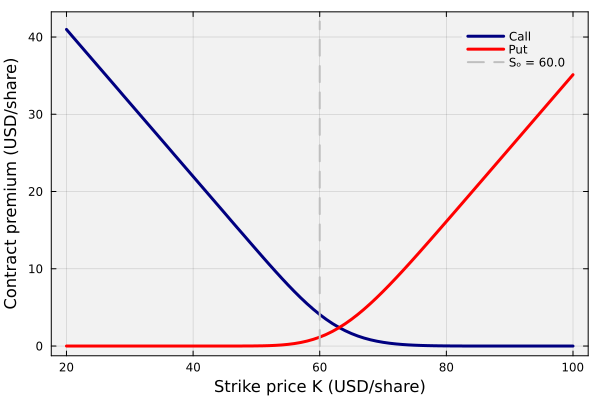

In [13]:
let
    plot(df_BSM_simulation[:,1], df_BSM_simulation[:,2], label="Call", lw=3, c=:navy);
    plot!(df_BSM_simulation[:,1], df_BSM_simulation[:,3], label="Put", lw=3, c=:red)
    vertical_line_y = range(0,step=0.1,stop=42) |> collect;
    vertical_line_x = Sₒ*ones(length(vertical_line_y));
    plot!(vertical_line_x,vertical_line_y, lw=2, c=:gray75, ls=:dash, label="Sₒ = 60.0")
    xlabel!("Strike price K (USD/share)", fontsize=18)
    ylabel!("Contract premium (USD/share)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);    
end

### Discussion
1. Why does the premium of a call option contract increase as $K\rightarrow{0}$ for $S_{0}$ = 60 USD/share? For example, what could you do if you purchased a call with a strike of $K=40$ USD/share?
2. Why does the premium of a put option contract increase as $K\rightarrow{\infty}$ for $S_{0}$ = 60 USD/share? For example, what could you do if you purchased a put with a strike of $K=80$ USD/share?

___

## Summary
In this example, we've computed premiums for European call and put options using Monte Carlo simulation and the Black-Scholes-Merton formula.

> __Key Takeaways:__
> 
> * __Monte Carlo simulation estimates option premiums__ by generating multiple asset price paths under risk-neutral dynamics and averaging the discounted payoffs at expiration.
> * __The Black-Scholes-Merton formula provides analytical premiums__ for European options based on current asset price, strike price, time to expiration, volatility, and risk-free rate.
> * __Option premiums vary systematically with strike price__ relative to the current asset price: call premiums decrease as strike increases, while put premiums increase as strike increases.

Mastering these pricing approaches is fundamental for quantitative analysis of European-style derivative contracts.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.